# Прогнозирование оттока клиентов в сети отелей

## Получение данных

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED=123

In [2]:
# загрузка датасета с обучающими данными
hotel_train = pd.read_csv('/datasets/hotel_train.csv')

In [3]:
# функция для получения общей информации
def get_info(df):
    display(df.shape)
    display(df.head())
    display(df.info())
    display(df.describe())
    display(df.isna().sum())

In [4]:
get_info(hotel_train)

(65229, 25)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [5]:
# загрузка тестовых данных
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

In [6]:
get_info(hotel_test)

(32412, 25)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

Оба датасета содержат 25 столбцов с информацией о бронировании номера:
- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
    - Contract — договор с юридическим лицом;
    - Group — групповой заезд;
    - Transient — не связано с договором или групповым заездом;
    - Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
    - SC — нет дополнительных опций;
    - BB — включён завтрак;
    - HB — включён завтрак и обед;
    - FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.


**Вывод:** загружена информация о датафреймах с обучающим набором данных `hotel_train` и тестовым `hotel_test`. Датасеты содержат одинаковые признаки и три типа данных: `float64`, `int64` и `object`; пропуски в датафреймах не обнаружены. Для числовых столбцов выведена информация о среднем, стандартном отклонении, квартилях и минимальном и максимальном значениях - по ним, на первый взгляд, можно судить об адекватности данных.

## Предобработка данных

Предобработка датасета заключается в преобразовании типов данных, проверки на явные и неявные дубликаты, удалении ненужных столбцов и переименовании названий колонок, если это необходимо.

### Преобразование типов данных

В столбцах `lead_time`, `adults`, `children`, `babies` изменю тип данных с вещественного `float64` на целочисленный `int64` с помощью метода astype().

In [7]:
hotel_train[['lead_time', 'adults', 'children', 'babies']] = hotel_train[
    ['lead_time', 'adults', 'children', 'babies']
].astype('int')

### Проверка на явные дубликаты

С помощью метода duplicated() осуществлю проверку на явные дубликаты:

In [8]:
hotel_train.duplicated().sum()

0

В датасете явных дубликатов не обнаружено.

### Проверка на неявные дубликаты

Методом unique() проверю стоблцы с категориальными переменными на неявные дубликаты:

In [9]:
categorical_columns = [
    'arrival_date_month', 'country', 'meal', 
    'distribution_channel', 'reserved_room_type', 
    'customer_type'
]

In [10]:
for column in categorical_columns:
    print(column, sorted(hotel_train[column].unique()), sep=': ', end='\n\n')

arrival_date_month: ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']

country: ['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 'NAM', 'NGA', 'NIC', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRI', 'PRT', 'PRY', 'PYF', 'QAT', 

Значения столбцов `meal` и `reserved_room_type` содержат пустые символы в конце строки, удалю их методом str.strip():

In [11]:
hotel_train['meal'] = hotel_train['meal'].str.strip()

In [12]:
hotel_train['meal'].unique() # проверка

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [13]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

In [14]:
hotel_train['reserved_room_type'].unique() # проверка

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

При получении информации о датафрейме методом describe() в количественных столбцах обнаружились аномальные значения. Посчитаю долю таких значений после чего приму решение, удалить или оставить такие данные:

In [15]:
hotel_train['babies'].unique() # вывод уникальных значений в столбце babies

array([ 0,  1,  2, 10,  9])

In [16]:
hotel_train.query('babies > 2')['babies'].count()

2

Очевидно, что количество младенцев 9 и 10 являются выбросами, таких строк в датасете всего две, поэтому удалю их из датафрейма:

In [17]:
hotel_train = hotel_train.query('babies <= 2').reset_index(drop=True)

В датасете с тестовой выборкой `hotel_test` также выполню проверку столбцов на уникальные значения.

In [18]:
for column in categorical_columns:
    print(column, sorted(hotel_test[column].unique()), sep=': ', end='\n\n')

arrival_date_month: ['April', 'August', 'February', 'January', 'July', 'June', 'March', 'May']

country: ['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM', 'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KIR', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MLT', 'MNE', 'MOZ', 'MRT', 'MUS', 'MYS', 'MYT', 'NCL', 'NGA', 'NLD', 'NOR', 'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRT', 'PRY', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 'SLV', 'SRB', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SYC', 'SYR', 'TGO',

Некоторые столбцы также содержат пустые символы в конце строки, удалю их:

In [19]:
hotel_test['meal'] = hotel_test['meal'].str.strip()

In [20]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()

### Группировка стран по частям света

Код страны с присвоением к части света взяла из открытого источника данных:

In [21]:
countries_list = pd.read_csv('https://www.artlebedev.ru/country-list/tab/', sep='\t')

In [22]:
countries_list = countries_list.dropna(subset=['location']).reset_index()
countries_list = countries_list[['alpha3', 'location']]
data = countries_list.to_dict('list')
side_of_world = dict(zip(data['alpha3'], data['location']))
side_of_world['CN'] = 'Азия'
side_of_world['TMP'] = 'Азия'

print(len(side_of_world))
print(tuple(side_of_world.items())[:10])

249
(('ABH', 'Азия'), ('AUS', 'Океания'), ('AUT', 'Европа'), ('AZE', 'Азия'), ('ALB', 'Европа'), ('DZA', 'Африка'), ('ASM', 'Океания'), ('AIA', 'Америка'), ('AGO', 'Африка'), ('AND', 'Европа'))


In [23]:
def get_side_of_world(row):
    return side_of_world.get(row['country'])

In [24]:
hotel_train['side_of_world'] = hotel_train.apply(get_side_of_world, axis=1)
hotel_test['side_of_world'] = hotel_test.apply(get_side_of_world, axis=1)
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,side_of_world
0,0,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,Европа
1,1,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,Европа
2,2,0,0,2015,July,27,1,0,2,2,0,0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,Европа
3,3,0,9,2015,July,27,1,0,2,2,0,0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,Европа
4,4,1,85,2015,July,27,1,0,3,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,Европа


In [25]:
hotel_train['side_of_world'].isna().sum()

0

In [26]:
hotel_test['side_of_world'].isna().sum()

1

In [27]:
hotel_test = hotel_test.dropna(subset=['side_of_world']).reset_index(drop=True)

In [28]:
hotel_test['side_of_world'].isna().sum()

0

### Удаление столбцов

Столбец с номером записи не потребуется для дальнейшего обучения модели, поэтому удалю его из обоих датафреймов. Также столбец `country` не понадобится для дальнейшего обучения, так как выполнена группировка по сторонам света.

In [29]:
hotel_train = hotel_train.drop(['id', 'country'], axis=1)
hotel_test = hotel_test.drop(['id', 'country'], axis=1)

## Исследовательский анализ данных

Исследовательский анализ данных позволяет лучше понять закономерности в данных, обнаружить выбросы или аномалии, а также найти интересные взаимосвязи между переменными с применением методов визуализации данных.

Гистограммы являются первоочередным инструментом для визуализации данных. По ним можно увидеть частоту распределения значений, соответствует ли распределение нормальному, есть ли выбросы, в каком диапазоне содержится большая часть значений, какое значение встречается чаще остальных.

Построю гистограммы для следующих параметров:

- количество дней между датой бронирования и датой прибытия `lead_time`;
- день заезда `arrival_date_day_of_month`;
- количество ночей в выходные дни `stays_in_weekend_nights`;
- количество ночей в будние дни `stays_in_week_nights`;
- количество взрослых постояльцев `adults`;
- количество детей от 3 до 14 лет `children`;
- количество младенцев `babies`;
- признак того, что гость бронирует номер второй раз `is_repeated_guest`;
- сколько дней заказ ожидал подтверждения `days_in_waiting_list`;
- общее количество ночей `total_night`.

In [30]:
plt.rcParams['figure.figsize'] = [7, 7]
sns.set_theme(style="whitegrid")

In [31]:
features = [
    'lead_time', 'arrival_date_day_of_month',
    'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
    'children', 'babies', 'is_repeated_guest',
    'days_in_waiting_list', 'total_nights'
]

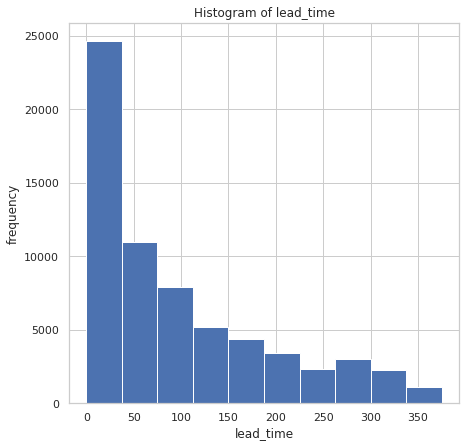

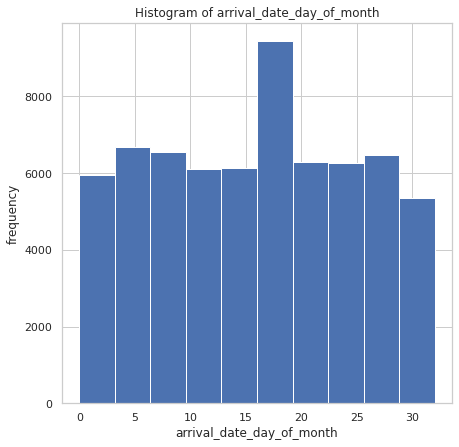

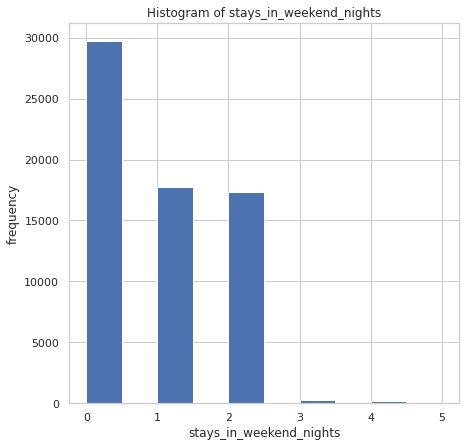

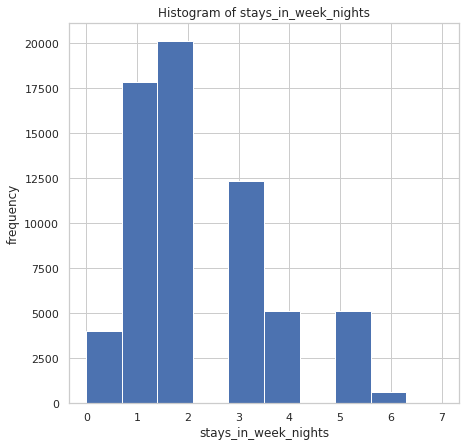

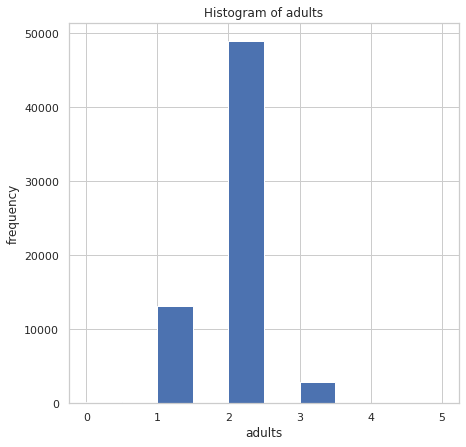

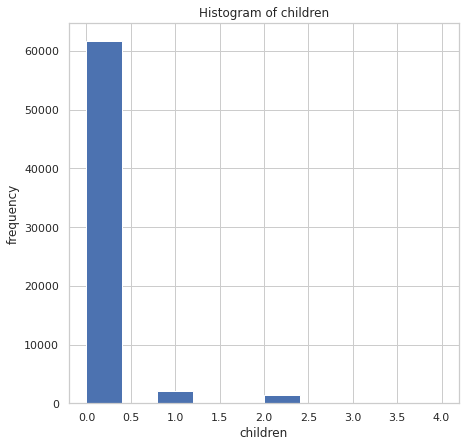

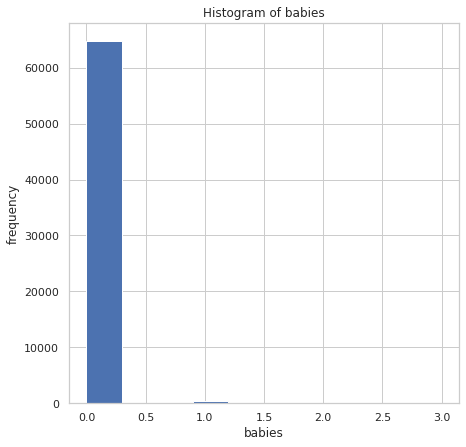

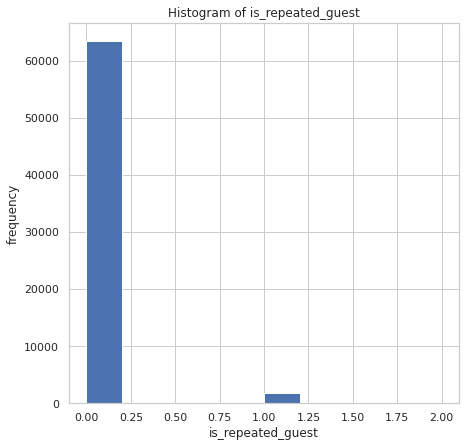

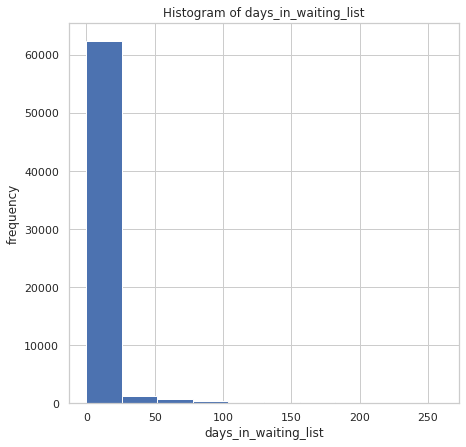

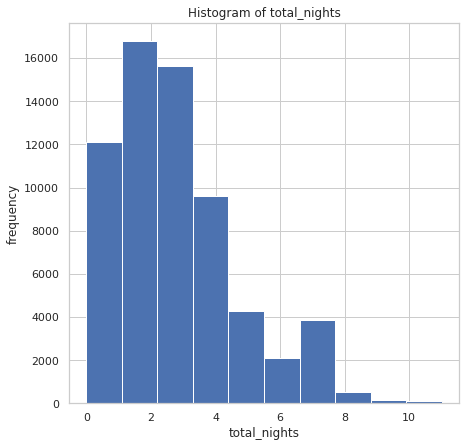

In [32]:
for value in features:
    max_value = hotel_train[value].max()
    hotel_train[value].hist(bins=10, range=(0, max_value+1))
    plt.xlabel(value)
    plt.ylabel('frequency')
    plt.title(f'Histogram of {value}')
    plt.show()

**Выводы по гистограммам:**
- `histogram of lead_time`: данные по количеству дней между датой бронирования и датой прибытия распределены нормально, 25 тыс. гостей бронировали номер в день заезда;
- `histogram of arrival_date_day_of_month`: середина месяца является наиболее популярным временем у гостей для посещения отеля:
- `histogram of stays_in_weekend_nights`: почти половина гостей отеля не останавливается в выходные дни,а очень редкие гости затрагивают от трех до четырех выходных дней;
- `histogram of stays_in_week_nights`: большая часть гостей останавливается от одного до трех будних дней;
- `histogram of adults`: на гистограмме видно аномальное значение - 0 взрослых постояльцев, такое наврятли может быть при заселении. Нужно посмотреть, какая доля таких строк от общего количества присутствует в датафрейме;
- `histogram of children`: более 60 тыс. постояльцев отеля заселялись без детей;
- `histogram of babies`: почти все гости заселялись без младенцев (в процессе анализа данных были обнаружены аномальные значения - 9 и 10, от таких строк я избавилась);
- `histogram of is_repeated_guest`: на гистограмме видно, что практически все гости бронировали номер в отеле впервые, то есть количество постоянных гостей очень мало;
- `histogram of days_in_waiting_list`: более 180 дней ожидания подтверждения заказа является редким явлением, поэтому посчитаю долю таких строк, чтобы принять решение, избаляться ли от таких строк;
- `histogram of total_night`: чаще всего постояльцы останавливались в отеле от 1-го до 3-х дней.

In [33]:
len(hotel_train.query('adults == 0')) # количество строк с нулевым значением взрослых постояльцев

166

In [34]:
round(len(hotel_train.query('adults == 0')) * 100 / len(hotel_train), 3) # процент аномальных значений

0.254

Доля строк с нулевым значением взрослых постояльцев от общего количества записей ~ 0,3% - это малая часть данных, избавлюсь от таких строк.

In [35]:
hotel_train = hotel_train.query('adults > 0').reset_index(drop=True)

In [36]:
# количество строк с ожиданием подтверждения заказа более 180 дней
len(hotel_train.query('days_in_waiting_list > 180'))

137

In [37]:
# процент аномальных значений
round(len(hotel_train.query('days_in_waiting_list > 180')) * 100 / len(hotel_train), 3)

0.211

Доля таких значений ~ 0,2% - это малая часть данных, избавлюсь от таких строк.

In [38]:
hotel_train = hotel_train.query('days_in_waiting_list < 180').reset_index(drop=True)

In [39]:
hotel_train.shape

(64924, 24)

Построю графики зависимости отмены брони от различных признаков:

Text(0.5, 1.0, 'number of cancelled rooms depending on total nights')

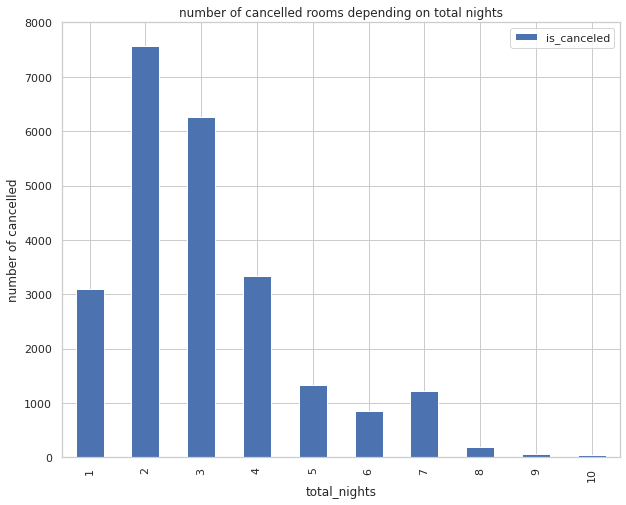

In [40]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='total_nights', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 8000), figsize=(10,8))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on total nights')

*Анализ графика:* по сгруппированным данным видно, что наиболее частая отмена бронирования совершалась клиентами при бронировании номера от 1 до 4-х ночей включительно (от 3 до 7,5 тыс отмен в этих группах).

Text(0.5, 1.0, 'number of cancelled rooms depending on reserved room type')

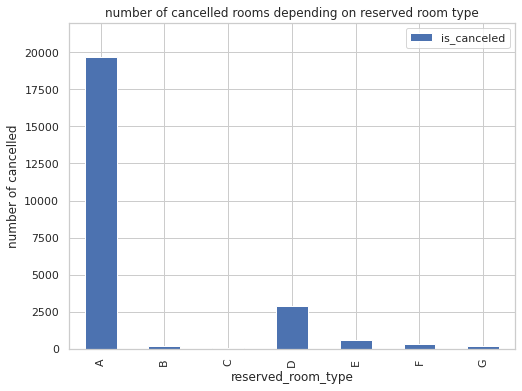

In [41]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='reserved_room_type', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 22000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on reserved room type')

*Анализ графика:* от типа номера зависит количество отмены брони: самая дорогая категория номера ("А") отменялась клиентами почти 20 тыс. раз.

Text(0.5, 1.0, 'number of cancelled rooms depending on customer_type')

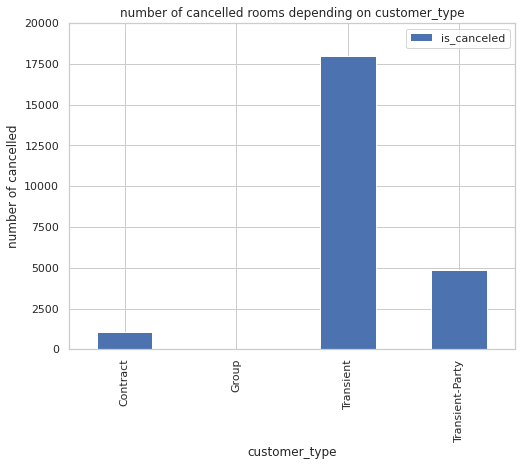

In [42]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='customer_type', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 20000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on customer_type')

*Анализ графика:* тип заказчика "Transient" больше остальных категорий отменяет бронь: в этой категории более 17,5 тыс. отмен.

Text(0.5, 1.0, 'number of cancelled rooms depending on children')

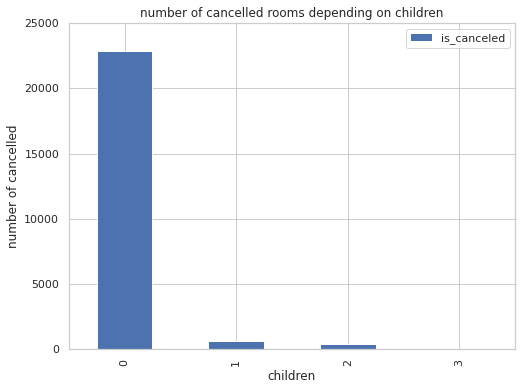

In [43]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='children', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 25000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on children')

*Анализ графика:* гости, которые планируют заселяться без детей намного чаще отменяют свою бронь: около 23 тыс. отмен наблюдается в этой группе. 

Text(0.5, 1.0, 'number of cancelled rooms depending on previous_cancellations')

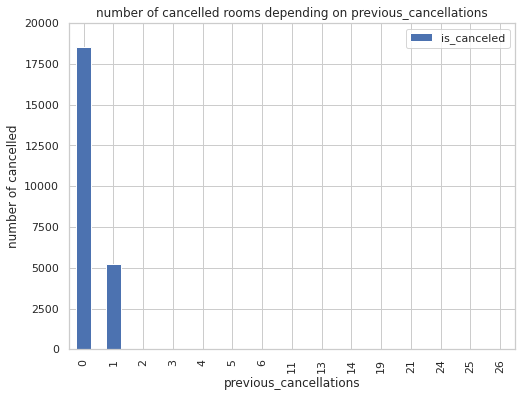

In [44]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='previous_cancellations', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 20000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on previous_cancellations')

*Анализ графика:* чаще отменяют бронь клиенты, которые до этого еще не совершали отмену брони.

Text(0.5, 1.0, 'number of cancelled rooms depending on total_of_special_requests')

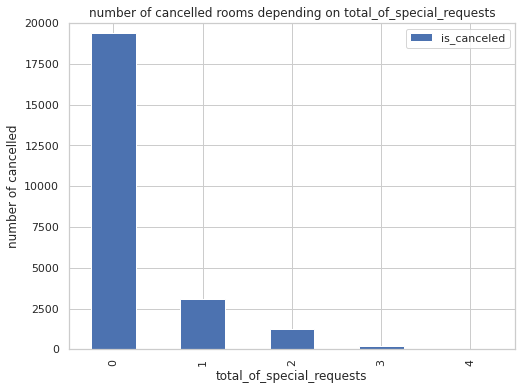

In [45]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='total_of_special_requests', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 20000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on total_of_special_requests')

*Анализ графика:* чем меньше специальных отметок у клиента в информации о бронировании, тем вероятнее будет отменена бронь.

Text(0.5, 1.0, 'number of cancelled rooms depending on meal')

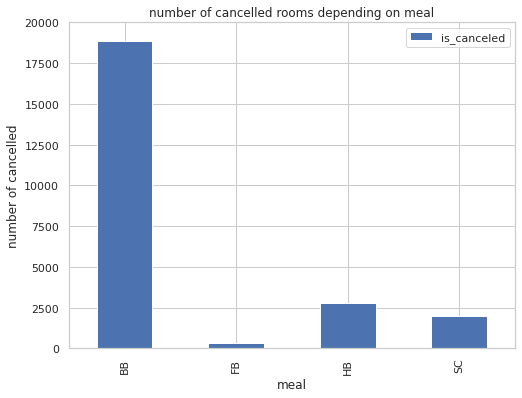

In [46]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='meal', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 20000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on meal')

*Анализ графика:* гости, которые выбирают опцию заказа "завтрак" больше остальных отменяют бронь.

Text(0.5, 1.0, 'number of cancelled rooms depending on booking changes')

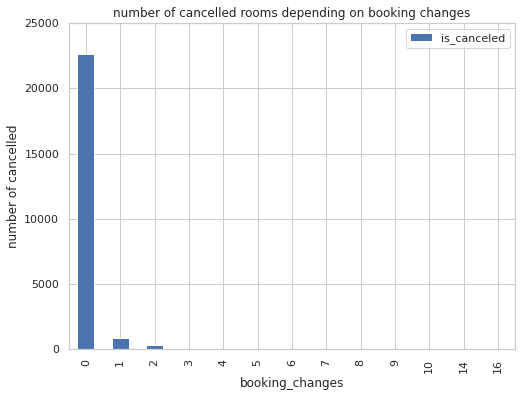

In [47]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='booking_changes', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 25000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on booking changes')

*Анализ графика:* при отсутствии изменений параметров заказа гость, вероятнее всего, отменит бронь.

Text(0.5, 1.0, 'number of cancelled rooms depending on adults')

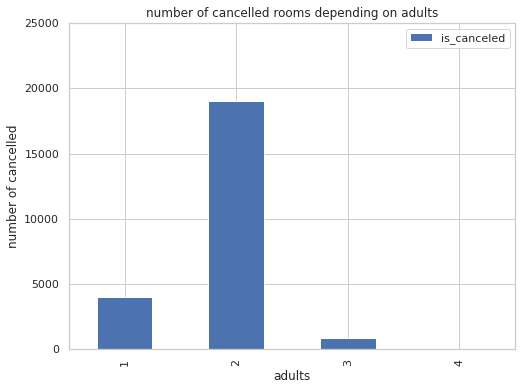

In [48]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='adults', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 25000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on adults')

*Анализ графика:* больше всего отменяют бронь те гости, которые планировали остановиться в отеле вдвоем - почти 20 тыс. отмен заказа. 

Text(0.5, 1.0, 'number of cancelled rooms depending on arrival date month')

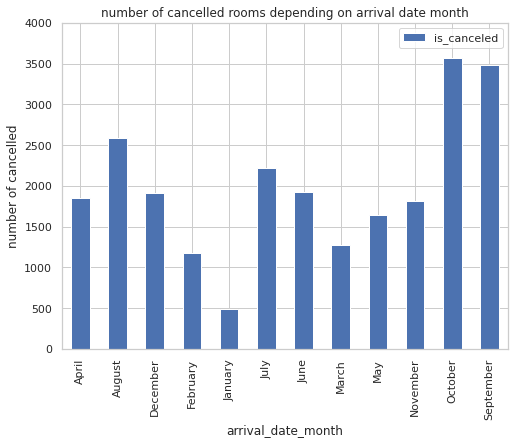

In [49]:
hotel_train.query('is_canceled == 1').pivot_table(
    index='arrival_date_month', values='is_canceled', aggfunc='count'
).plot(kind='bar', ylim=(0, 4000), figsize=(8,6))
plt.ylabel('number of cancelled')
plt.title('number of cancelled rooms depending on arrival date month')

*Анализ графика:* по распределению отмененных заказов в зависимости от месяца видно, что меньше всего отменяют бронь в январе, а больше всего в осенние месяцы - сентябрь и октябрь.

**Общий вывод:** в ходе предобработки и исследовательского анализа данных были выявлены некорректные значения в колонках и выбросы; построены гистограммы с распредением частоты признака, а также построены графики зависимости отмены брони от различных признаков для составления портрета клиента, склонного к отказу от брони.

## Формулировка ML-задачи на основе бизнес-задачи

### Вычисление бизнес-метрики

Бизнес-задача заключается в определении прибыли от внедрения модели машинного обучения, которая будет выявлять потенциальных клиентов, которые склонны к отказу от бронирования. Соответственно, бизнес-метрикой является прибыль. Она рассчитывается как разность между выручкой с внедрением системы прогнозирования оттока и выручкой без внедрения системы за один год. На разработку системы прогнозирования заложен бюджет - 400 тыс. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Чтобы посчитать прибыль без внедрения депозита создам новый датафрейм `hotel_profit`:

In [50]:
hotel_profit = hotel_train.loc[
    :, ['is_canceled', 'reserved_room_type', 'arrival_date_month', 'total_nights', 'arrival_date_year']
]

In [51]:
def group_cost(row):
    if row['reserved_room_type'] == 'A':
        return 1000
    elif row['reserved_room_type'] == 'B':
        return 800
    elif row['reserved_room_type'] == 'C':
        return 600
    elif row['reserved_room_type'] == 'D':
        return 550
    elif row['reserved_room_type'] == 'E':
        return 500
    elif row['reserved_room_type'] == 'F':
        return 450
    elif row['reserved_room_type'] == 'G':
        return 350
    
hotel_profit['cost_room'] = hotel_profit.apply(group_cost, axis=1)

In [52]:
def group_service(row):
    if row['reserved_room_type'] == 'A':
        return 400
    elif row['reserved_room_type'] in {'B', 'C'}:
        return 350
    else:
        return 150
    
hotel_profit['one_time_room_service'] = hotel_profit.apply(group_service, axis=1)

In [53]:
def group_coefficient(row):
    if row['arrival_date_month'] in {'June', 'July', 'August'}:
        return 1.4
    elif row['arrival_date_month'] in {'December', 'January', 'February'}:
        return 1
    else:
        return 1.2
    
hotel_profit['seasonal_coefficient'] = hotel_profit.apply(group_coefficient, axis=1)

In [54]:
def calc_cleaning(row):
    if row['total_nights'] in {1, 2}:
        return 1
    elif row['total_nights'] > 2:
        return row['total_nights'] // 2 + 1
    
hotel_profit['count_cleaning'] = hotel_profit.apply(calc_cleaning, axis=1)

In [55]:
hotel_profit.head(10)

,is_canceled,reserved_room_type,arrival_date_month,total_nights,arrival_date_year,cost_room,one_time_room_service,seasonal_coefficient,count_cleaning
0,0,A,July,1,2015,1000,400,1.4,1
1,0,A,July,2,2015,1000,400,1.4,1
2,0,C,July,2,2015,600,350,1.4,1
3,0,C,July,2,2015,600,350,1.4,1
4,1,A,July,3,2015,1000,400,1.4,2
5,1,D,July,3,2015,550,150,1.4,2
6,1,E,July,4,2015,500,150,1.4,3
7,0,G,July,4,2015,350,150,1.4,3
8,0,D,July,4,2015,550,150,1.4,3
9,0,E,July,4,2015,500,150,1.4,3


Прибыль рассчитывается как разность между выручкой и убытками. Если гость отменил бронь, то отель терпит убытки, которые рассчитываются как стоимость номера за одну ночь, умноженную на сезонный коэффициент. 

In [56]:
"""Функция расчета прибыли"""

def calc_profit(row):
    if row['is_canceled'] == 0:
        # стоимость за все ночи
        revenue_0 = row['total_nights'] * row['cost_room'] * row['seasonal_coefficient']
        losses_0 = row['one_time_room_service'] * row['count_cleaning']
        return revenue_0 - losses_0
    elif row['is_canceled'] == 1:
        # убыток за 1 ночь
        losses_1 = row['cost_room'] * row['seasonal_coefficient']
        return -losses_1
    
hotel_profit['profit'] = hotel_profit.apply(calc_profit, axis=1)    

In [57]:
hotel_profit.head(10)

,is_canceled,reserved_room_type,arrival_date_month,total_nights,arrival_date_year,cost_room,one_time_room_service,seasonal_coefficient,count_cleaning,profit
0,0,A,July,1,2015,1000,400,1.4,1,1000.0
1,0,A,July,2,2015,1000,400,1.4,1,2400.0
2,0,C,July,2,2015,600,350,1.4,1,1330.0
3,0,C,July,2,2015,600,350,1.4,1,1330.0
4,1,A,July,3,2015,1000,400,1.4,2,-1400.0
5,1,D,July,3,2015,550,150,1.4,2,-770.0
6,1,E,July,4,2015,500,150,1.4,3,-700.0
7,0,G,July,4,2015,350,150,1.4,3,1510.0
8,0,D,July,4,2015,550,150,1.4,3,2630.0
9,0,E,July,4,2015,500,150,1.4,3,2350.0


Выведу выручку отеля за каждый год отдельно:

In [58]:
hotel_profit.groupby(['arrival_date_year']).profit.sum()

arrival_date_year
2015    21243620.0
2016    56361860.0
Name: profit, dtype: float64

Далее посчитаю прибыль без внедрения депозита для 2017 года (за 8 месяцев) по данным тестовой выборки `hotel_test`:

In [59]:
hotel_test_profit = hotel_test.loc[
    :, ['is_canceled', 'reserved_room_type', 'arrival_date_month', 'total_nights', 'arrival_date_year']
]

In [60]:
hotel_test_profit['cost_room'] = hotel_test_profit.apply(group_cost, axis=1)
hotel_test_profit['one_time_room_service'] = hotel_test_profit.apply(group_service, axis=1)
hotel_test_profit['seasonal_coefficient'] = hotel_test_profit.apply(group_coefficient, axis=1)
hotel_test_profit['count_cleaning'] = hotel_test_profit.apply(calc_cleaning, axis=1)
    
hotel_test_profit['profit'] = hotel_test_profit.apply(calc_profit, axis=1)

In [61]:
hotel_test_profit.groupby(['arrival_date_year']).profit.sum()

arrival_date_year
2017    38192370.0
Name: profit, dtype: float64

Выведу среднюю выручку за год по данным 2015, 2016 и 2017 гг. (за 2015 год есть информация за 6 мес., за 2016 год - за 12 мес.,  за 2017 год - за 8 мес. )

In [62]:
profit_2015 = hotel_profit.query('arrival_date_year == 2015')['profit'].sum()
profit_2015

21243620.0

In [63]:
profit_2016 = hotel_profit.query('arrival_date_year == 2016')['profit'].sum()
profit_2016

56361860.0

In [64]:
profit_2017 = hotel_test_profit['profit'].sum()
profit_2017

38192370.0

Посчитаю среднюю прибыль за 8 месяцев по данным за 2015-2017 гг. (далее нужно сравнивнивать выручку до внедрения модели и после внедрения за 2017 год, а в тестовом датасете предоставлены данные за 8 месяцев).

In [65]:
mean_profit_eight_months = round((profit_2015 + profit_2016 + profit_2017) / 26 * 8, 1)
mean_profit_eight_months

35630107.7

**Вывод:** посчитана средняя прибыль отеля за 8 месяцев без внедрения депозита - 35 630 107 руб.

## Подготовка признаков и разработка модели ML

На данном шаге передо мной стоит задача разработать систему, которая предсказывает отказ от брони. В исходном датасете `hotel_train` в столбце `is_canceled` находится целевой признак, в котором "0" - отрицательный класс (клиент не отменил бронь), "1" - положительный (клиент отменил бронь). Решается задача бинарной классификации.

Обучу модели дерева решений, случайного леса и логистической регрессии и оценю их качество кросс-валидацией. Для обучения выберу **ключевую метрику F1-меру**, которая является средним гармоническим точности `precision` и полноты `recall`. Использую именно эту метрику, так как важно оценить качество прогноза положительного класса с разных позиций: полнота описывает, как хорошо модель разобралась в особенностях этого класса и распознала его, точность выявляет, не переусердствует ли модель, присваивая положительные метки.

Перед обучением моделей необходимо подготовить признаки датафреймов `hotel_train` и `hotel_test`, а именно:

- отмасштабировать признаки техникой стандартизации данных;
- исследовать на предмет дисбаланса классов;
- выполнить кодирование категориальных признаков техникой One-Hot-Encoding.

### Разделение данных на выборки

Для каждого датафрейма категориальный целевой признак определю в переменную `target`, остальные признаки - в переменную `features`.

In [66]:
features_train = hotel_train.drop(['is_canceled'], axis=1)
target_train = hotel_train['is_canceled']

In [67]:
features_test = hotel_test.drop(['is_canceled'], axis=1)
target_test = hotel_test['is_canceled']

In [68]:
# размеры полученных выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(64924, 23)
(64924,)
(32411, 23)
(32411,)


In [69]:
features_train.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'side_of_world'],
      dtype='object')

In [70]:
features_test.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'side_of_world'],
      dtype='object')

### Масштабирование признаков

Так как у всех количественных признаков разный масштаб, то воспользуюсь методом масштабирования таким как стандартизация признаков. Для этого в отдельную переменную положу список столбцов с количественными переменными.

In [71]:
numeric = [
    'lead_time', 'arrival_date_year', 'arrival_date_week_number',
    'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
    'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'
]

In [72]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

### Исследование на предмет дисбаланса классов

Классы считаются несбалансированными, когда их соотношение не равно 1:1. Посчитаю, как соотносятся классы в исходном датасете.

In [73]:
hotel_train.query('is_canceled == 1').shape # положительный класс "1"

(23942, 24)

In [74]:
hotel_train.query('is_canceled == 0').shape # отрицательный класс "0"

(40982, 24)

Присутствует дисбаланс классов. Отрицательный класс превышает положительный в 1.7 раза. При обучении моделей буду задавать параметр веса классов `class_weight=balanced`.

### Техника прямого кодирования

В датасете содержатся столбцы с количественными и категориальными признаками. Преобразую категориальные признаки `arrival_date_month meal`, `side_of_world`, `distribution_channel`, `reserved_room_type`, `customer_type` в количественные с помощью техники прямого кодирования One-Hot-Encoding.

In [75]:
categorical_columns = [
    'meal', 'side_of_world', 'distribution_channel',
    'reserved_room_type', 'customer_type',
    'arrival_date_month'
]

- обучающая выборка:

In [76]:
features_train_encoder = features_train.loc[:]

encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(features_train_encoder[categorical_columns])
features_train_encoded = encoder.transform(features_train_encoder[categorical_columns]).toarray()
features_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Преобразование массива закодированных столбцов в датафрейм:

In [77]:
features_train_df = pd.DataFrame(
    features_train_encoded, 
    columns=encoder.get_feature_names(categorical_columns),
    index=features_train.index
)
features_train_df.head()

,meal_FB,meal_HB,meal_SC,side_of_world_Америка,side_of_world_Антарктика,side_of_world_Африка,side_of_world_Европа,side_of_world_Океания,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
features_train_drop = features_train.drop(categorical_columns + ['arrival_date_year'], axis=1)
features_train_drop.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,-0.927682,-0.324662,-1.69657,-0.967171,-0.902325,-1.781458,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-1.177685
1,-0.854672,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.602845
2,-1.000691,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-0.602845
3,-0.906822,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.602845
4,-0.114144,-0.324662,-1.69657,-0.967171,0.573046,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.028005


In [79]:
features_train_ohe = pd.concat((features_train_drop, features_train_df), axis=1)
features_train_ohe.head(10)

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,meal_FB,meal_HB,meal_SC,side_of_world_Америка,side_of_world_Антарктика,side_of_world_Африка,side_of_world_Европа,side_of_world_Океания,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,-0.927682,-0.324662,-1.69657,-0.967171,-0.902325,-1.781458,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-1.177685,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.854672,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.602845,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.000691,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-0.602845,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.906822,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.602845,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.114144,-0.324662,-1.69657,-0.967171,0.573046,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.028005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.218444,-0.324662,-1.69657,-0.967171,0.573046,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-0.028005,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.760802,-0.324662,-1.69657,-0.967171,1.310732,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.812952,-0.324662,-1.69657,-0.967171,1.310732,0.336729,2.895105,-0.082988,0,-0.133851,-0.081373,1.360701,-0.187387,-0.244605,0.647681,0.546835,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.291453,-0.324662,-1.69657,-0.967171,1.310732,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,3.305962,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.614782,-0.324662,-1.69657,-0.967171,1.310732,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


- тестовая выборка:

In [80]:
features_test_encoder = features_test.loc[:]
features_test_encoded = encoder.transform(features_test_encoder[categorical_columns]).toarray()
features_test_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
features_test_df = pd.DataFrame(
    features_test_encoded, 
    columns=encoder.get_feature_names(categorical_columns),
    index=features_test.index
)
features_test_df.head()

,meal_FB,meal_HB,meal_SC,side_of_world_Америка,side_of_world_Антарктика,side_of_world_Африка,side_of_world_Европа,side_of_world_Океания,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
features_test_drop = features_test.drop(categorical_columns + ['arrival_date_year'], axis=1)
features_test_drop.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,-0.228873,-2.256183,-1.69657,0.204399,-1.640011,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-1.177685
1,-0.354033,-2.256183,-1.69657,1.375969,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835
2,-0.354033,-2.256183,-1.69657,1.375969,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835
3,-0.260163,-2.256183,-1.69657,1.375969,-0.164640,-1.781458,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835
4,0.793264,-2.256183,-1.69657,1.375969,2.048417,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,2.271354


In [83]:
features_test_ohe = pd.concat((features_test_drop, features_test_df), axis=1)
features_test_ohe.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,meal_FB,meal_HB,meal_SC,side_of_world_Америка,side_of_world_Антарктика,side_of_world_Африка,side_of_world_Европа,side_of_world_Океания,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,-0.228873,-2.256183,-1.69657,0.204399,-1.640011,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-1.177685,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.354033,-2.256183,-1.69657,1.375969,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.354033,-2.256183,-1.69657,1.375969,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.260163,-2.256183,-1.69657,1.375969,-0.164640,-1.781458,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.793264,-2.256183,-1.69657,1.375969,2.048417,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,2.271354,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
display(features_train_ohe.head())
display(features_test_ohe.head())

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,meal_FB,meal_HB,meal_SC,side_of_world_Америка,side_of_world_Антарктика,side_of_world_Африка,side_of_world_Европа,side_of_world_Океания,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,-0.927682,-0.324662,-1.69657,-0.967171,-0.902325,-1.781458,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-1.177685,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.854672,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.602845,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.000691,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-0.602845,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.906822,-0.324662,-1.69657,-0.967171,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.602845,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.114144,-0.324662,-1.69657,-0.967171,0.573046,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,-0.028005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,meal_FB,meal_HB,meal_SC,side_of_world_Америка,side_of_world_Антарктика,side_of_world_Африка,side_of_world_Европа,side_of_world_Океания,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,-0.228873,-2.256183,-1.69657,0.204399,-1.640011,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,-1.177685,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.354033,-2.256183,-1.69657,1.375969,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.354033,-2.256183,-1.69657,1.375969,-0.164640,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.260163,-2.256183,-1.69657,1.375969,-0.164640,-1.781458,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,0.647681,0.546835,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.793264,-2.256183,-1.69657,1.375969,2.048417,0.336729,-0.219578,-0.082988,0,-0.133851,-0.081373,-0.326731,-0.187387,-0.244605,-0.681460,2.271354,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Подбор гиперпараметров GridSearchCV

Подбор наилучших гиперпараметров реализую с помощью модели GridSearchCV.

- *Logistic Regression*

In [85]:
model_logistic_regression = LogisticRegression(random_state=SEED)

In [86]:
parametrs = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.5, 1.0],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced']
}

In [87]:
%%time
grid = GridSearchCV(model_logistic_regression, parametrs, n_jobs=-1, cv=8, scoring='f1')
grid.fit(features_train_ohe, target_train)

CPU times: user 5min 11s, sys: 49.5 s, total: 6min 1s
Wall time: 6min 1s


GridSearchCV(cv=8, estimator=LogisticRegression(random_state=123), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [88]:
grid.best_params_

{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

**Лучшие гиперпараметры Logistic Regression: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}**

- *Random Forest*

In [89]:
model_random_forest = RandomForestClassifier(random_state=SEED)

In [90]:
parametrs = {
    'n_estimators': [75, 100, 125],
    'max_depth': [10, 15, 20],
    'max_features': [5, 7],
    'class_weight': ['balanced']
}

In [91]:
%%time
grid = GridSearchCV(model_random_forest, parametrs, n_jobs=-1, verbose=1, cv=8, scoring='f1')
grid.fit(features_train_ohe, target_train)

Fitting 8 folds for each of 18 candidates, totalling 144 fits
CPU times: user 8min 2s, sys: 1.1 s, total: 8min 3s
Wall time: 8min 4s


GridSearchCV(cv=8, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 15, 20], 'max_features': [5, 7],
                         'n_estimators': [75, 100, 125]},
             scoring='f1', verbose=1)

In [92]:
grid.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'max_features': 7,
 'n_estimators': 75}

**Лучшие гиперпараметры Random Forest: {'max_depth': 10, 'max_features': 7, 'n_estimators': 75}**

- *Decision Tree*

In [93]:
model_decision_tree = DecisionTreeClassifier(random_state=SEED)

In [94]:
parametrs = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'class_weight': ['balanced']
}

In [95]:
%%time
grid = GridSearchCV(model_decision_tree, parametrs, n_jobs=-1, verbose=1, cv=8, scoring='f1')
grid.fit(features_train_ohe, target_train)

Fitting 8 folds for each of 27 candidates, totalling 216 fits
CPU times: user 56.7 s, sys: 30.9 ms, total: 56.7 s
Wall time: 56.8 s


GridSearchCV(cv=8, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 15, 20],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1', verbose=1)

In [96]:
grid.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

**Лучшие гиперпараметры Decision Tree: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}**

С подобранными гиперпараметрами буду обучать модели на кросс-валидации и выбирать наилучшую.

## Обучение моделей на кросс-валидации

In [97]:
%%time
"""Модель логистической регрессии"""

model_logistic_regression = LogisticRegression(
    C=1.0, 
    penalty='l2', 
    solver='lbfgs', 
    random_state=SEED,
    class_weight = 'balanced',
    n_jobs=-1
)
scores = cross_val_score(
    model_logistic_regression, features_train_ohe, target_train, cv=20, scoring='f1'
)
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.5066949820884519
Качество модели для выборок: [0.46942446 0.47043919 0.60313199 0.57860616 0.41949521 0.31987891
 0.32329085 0.4848736  0.43060361 0.50799624 0.52782462 0.47283195
 0.45770532 0.44609403 0.41410843 0.34950019 0.71441361 0.7509434
 0.70894103 0.68379686]
CPU times: user 1min 11s, sys: 59 s, total: 2min 10s
Wall time: 2min 11s


In [98]:
%%time
"""Модель случайного леса"""

model_random_forest = RandomForestClassifier(
    max_depth=10,  
    n_estimators=75,
    max_features=7,
    class_weight = 'balanced',
    random_state=SEED,
    n_jobs=-1
)
scores = cross_val_score(
    model_random_forest, features_train_ohe, target_train, cv=20, scoring='f1'
)
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.5716252953688905
Качество модели для выборок: [0.39937271 0.47306034 0.57204533 0.62746899 0.50141911 0.40438356
 0.28507596 0.56379019 0.62795521 0.76416337 0.67867616 0.55838001
 0.59343545 0.53912296 0.47599839 0.3889159  0.82155113 0.81740322
 0.66542289 0.67486503]
CPU times: user 46.3 s, sys: 287 ms, total: 46.6 s
Wall time: 47 s


In [99]:
%%time
"""Модель решающего дерева"""

model_decision_tree = DecisionTreeClassifier(
    max_depth=10,  
    min_samples_leaf=3,
    min_samples_split=2,
    class_weight = 'balanced',
    random_state=SEED
)
scores = cross_val_score(
    model_decision_tree, features_train_ohe, target_train, cv=20, scoring='f1'
)
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.5075146052697568
Качество модели для выборок: [0.51912046 0.4543234  0.52675761 0.64670174 0.50516351 0.35032812
 0.39168911 0.55506047 0.40199005 0.78137128 0.31217482 0.32096774
 0.42428571 0.48273155 0.53656532 0.30971512 0.68439108 0.73710226
 0.56341702 0.64643573]
CPU times: user 4.59 s, sys: 7.35 ms, total: 4.6 s
Wall time: 4.61 s


**Вывод:** по результатам кросс-валидации лучшая оценка качества у модели случайного леса - 0.5716. Далее обучу эту модель на обучающем датасете и выведу значение F1-меры.

In [100]:
# результат на тестовой выборке
model_random_forest = RandomForestClassifier(
    max_depth=10,  
    n_estimators=75,
    max_features=7,
    class_weight = 'balanced',
    random_state=SEED
)
model_random_forest.fit(features_train_ohe, target_train)

predictions_test_rf = model_random_forest.predict(features_test_ohe)
f1_score_rf = f1_score(target_test, predictions_test_rf)

print("F1-мера для модели случайного леса на тестовой выборке:", f1_score_rf)

F1-мера для модели случайного леса на тестовой выборке: 0.6199709800817834


**Вывод:** таким образом, модель случайного леса выбрана для прогнозирования оттока клиентов. Она показывает ключевую метрику F1-меру, равную 0.6199 со средней оценкой качества модели ~ 0.5716.

## ROC-кривая и исследование метрики ROC-AUC

Построю ROC-кривую для своей модели и для случайной:

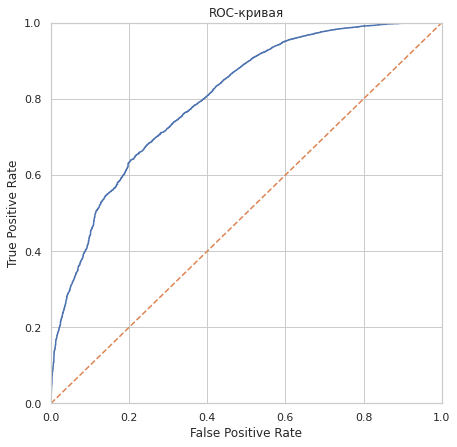

In [101]:
probabilities_test = model_random_forest.predict_proba(features_test_ohe)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Чтобы оценить, насколько модель отличается от случайной, вычислю площадь под кривой - AUC-ROC - метрика качества, которая может находиться в диапазоне от 0 до 1, а для случайной модели AUC-ROC равняется 0.5.

In [102]:
auc_roc_decision_tree = roc_auc_score(target_test, probabilities_one_test)
auc_roc_decision_tree

0.8011576229589457

**Вывод:** метрика качества AUC-ROC достаточно выше 0.5, что позволяет сделать вывод, что обученная модель случайного леса предсказывает лучше случайной.

## Расчет прибыли с учетом прогноза оттока клиентов

In [103]:
hotel_test['predicted'] = predictions_test_rf

In [104]:
"""Функция расчета прибыли с учетом прогнозирования оттока клиентов"""

def calc_model_profit(row):
    room_price = group_cost(row)
    seasonal_coefficient = group_coefficient(row)
    service_cost = group_service(row)
    
    if row['predicted'] == 1 and row['is_canceled'] == 1:
        # депозит 80% от стоимости номера за 1 ночь
        return (room_price*seasonal_coefficient + service_cost) * 0.8
    elif row['predicted'] == 0 and row['is_canceled'] == 1:
        # убыток за 1 ночь
        return -room_price*seasonal_coefficient
    else:
        # стоимость за все ночи
        count_cleaning = calc_cleaning(row)
        revenue_0 = row['total_nights'] * room_price * seasonal_coefficient
        losses_0 = service_cost * count_cleaning
        return revenue_0 - losses_0
    
hotel_test['profit_predicted'] = hotel_test.apply(calc_model_profit, axis=1)    

In [105]:
profit_predicted_2017 = hotel_test['profit_predicted'].sum()
profit_predicted_2017

54310072.0

Посчитаю выручку, которую принесет система прогнозирования компании за 8 месяцев:

In [106]:
round(profit_predicted_2017 - mean_profit_eight_months, 1)

18679964.3

In [107]:
round(profit_predicted_2017 / mean_profit_eight_months, 2)

1.52

**Вывод:** сравниваем прибыль до внедрения модели и после внедрения за 8 месяцев, так как в тестовом датасете предоставлены данные за неполный год. И поскольку выручка увеличилась в 1,5 раза за предоставленые 8 месяцев, можно сказать, что модель точно окупится за один год.
Полученная выручка составляет более ~ 18.7 млн. за 8 месяцев, что превышает затраты на разработку системы прогнозирования оттока.

## Описание портрета «ненадёжного» клиента

Портрет клиента, который считается "ненадёжным" выглядит следующим образом: клиент является частным лицом, бронирует самую дорогую категорию номера («А») для проживания двух человек, без детей, планирует остановиться от 1 до 4-х дней включительно в осенние месяцы – сентябрь и октябрь и в качестве опции заказа выбирает «завтрак». Также не делает специальных отметок в информации о бронировании, не изменяет параметров заказа и до этого еще не совершал отмену брони.

## Общий вывод

Для решения поставленной задачи были обучены три модели ML и по результатам кросс-валидации выбрана лучшая - **модель случайного леса** с гиперпараметрами:
- max_depth = 10;  
- n_estimators = 75;
- max_features = 7.

На тестовых данных модель показала **значение метрики F1-меры равное 0.6199**. Качество модели, проверенное кросс-валидацией, составляет 0.5716.

Рассчитана бизнес-метрика: прибыль после внедрения модели, ее значение составило **18 679 964 руб.**, что **в 1,5 раза больше** прибыли до внедрения системы прогнозирования оттока.

**Портрет "ненадёжного" клиента для заказчика:**  клиент является частным лицом, бронирует самую дорогую категорию номера («А») для проживания двух человек, без детей, планирует остановиться от 1 до 4-х дней включительно в осенние месяцы – сентябрь и октябрь и в качестве опции заказа выбирает «завтрак». Также не делает специальных отметок в информации о бронировании, не изменяет параметров заказа и до этого еще не совершал отмену брони.
